In [1]:
from fastai.vision.all import *

## 1. Data

In [2]:
def paths():
    path_root = Path('/media/ben/Ubuntu 20_04_4 LTS amd64/submeeting_2022/submeeting_images/')
    path_dataset = path_root/'total_images_su/total_320x240_su/'
    path_dataframe = path_root/'pickle_dataframes/df_total_unique_folder.pkl'
    path_pickle = path_root/'pickle_dataframes/'
    path_save_models =Path('/media/ben/Data_linux/code/submeeting_code/notebook/models/')
    print(path_dataset)
    print(path_dataframe)
    return path_root, path_dataset, path_dataframe, path_pickle, path_save_models

path_root, path_dataset, path_dataframe, path_pickle, path_save_models = paths()

/media/ben/Ubuntu 20_04_4 LTS amd64/submeeting_2022/submeeting_images/total_images_su/total_320x240_su
/media/ben/Ubuntu 20_04_4 LTS amd64/submeeting_2022/submeeting_images/pickle_dataframes/df_total_unique_folder.pkl


In [3]:
df_new = pd.read_pickle(path_pickle/'df_new_unique_folder.pkl')
df = df_new.drop_duplicates(subset=['fname']).reset_index(drop=True)
print(df.head())
print(df.tail())

class DataDistribution:
    """ create a dictionary with class and plot an histogram"""
    def __init__(self, df):
        self.df = df
        
    
    def data_dict(self):
        """ fonction to return a dictionnary with the number of images per classes"""

        classes = ['algen', 'divers', 'robots', 'rocks', 'sand', 'structure', 'water_only']

        algen_rocks = df.loc[df.labels=='algen rocks', 'labels'].count() #03
        algen_sand = df.loc[df.labels=='algen sand', 'labels'].count()   #04
        algen_rocks_sand = df.loc[df.labels=='algen rocks sand', 'labels'].count() #034
        algen_rocks_sand_structure = df.loc[df.labels=='algen rocks sand structure', 'labels'].count() #0345
        algen_sand_structure = df.loc[df.labels=='algen sand structure', 'labels'].count() #045
        algen_rocks_structure = df.loc[df.labels=='algen rocks structure', 'labels'].count()  #035
        algen_rocks_robots = df.loc[df.labels=='algen rocks robots', 'labels'].count() #023
        algen_rocks_robots_structure = df.loc[df.labels=='algen rocks robots structure', 'labels'].count() #0235
        algen_divers_rocks = df.loc[df.labels=='algen divers rocks', 'labels'].count()       #013                                        
        algen_rocks_robots_sand = df.loc[df.labels=='algen rocks robots sand', 'labels'].count() #0234
        water = df.loc[df.labels=='water_only', 'labels'].count()   #6
        robots_structure = df.loc[df.labels=='robots structure', 'labels'].count() #25
        divers = df.loc[df.labels=='divers', 'labels'].count() #1
        robots = df.loc[df.labels=='robots', 'labels'].count() #2

        dict_multiclass = {'03':algen_rocks,
                       '04':algen_sand,
                       '034':algen_rocks_sand,
                       '0345':algen_rocks_sand_structure,
                       '045':algen_sand_structure,
                       '035':algen_rocks_structure,
                       '023':algen_rocks_robots,
                       '0235':algen_rocks_robots_structure, 
                       '013': algen_divers_rocks,
                       '0234': algen_rocks_robots_sand,
                        '6': water,
                        '25': robots_structure,
                        '1': divers,
                        '2': robots
                            }
        return dict_multiclass
    
    def plot_hist(self):
        dfhist = pd.Series(self.data_dict(), index =['03', '04', '034', '0345',
                                            '045', '035','023','0235','013','0234','6', '25', '1', '2'])
        dfhist.plot.bar()
        plt.xlabel('class')
        plt.ylabel('number')


           fname            labels  is_valid
0  000000_b2.jpg  algen rocks sand      True
1  000025_b2.jpg  algen rocks sand     False
2  000050_b2.jpg  algen rocks sand     False
3  000075_b2.jpg  algen rocks sand      True
4  000100_b2.jpg  algen rocks sand     False
             fname      labels  is_valid
743  005950_p4.jpg  water_only     False
744  005975_p4.jpg  water_only     False
745  006000_p4.jpg  water_only     False
746  006025_p4.jpg  water_only      True
747  006050_p4.jpg  water_only     False


{'03': 385, '04': 10, '034': 53, '0345': 72, '045': 1, '035': 64, '023': 9, '0235': 23, '013': 17, '0234': 0, '6': 92, '25': 2, '1': 3, '2': 17}


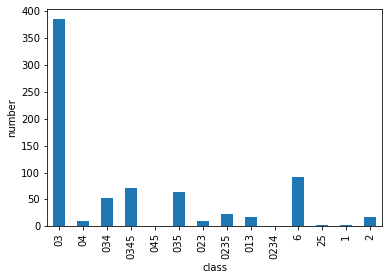

In [4]:
D1 = DataDistribution(df)
print(D1.data_dict())
D1.plot_hist()

In [5]:
def check():
    dict_multiclass = D1.data_dict()
    total = sum(dict_multiclass.values())
    print(f"total number of images: {total}")

    assert(total == df.shape[0])
check()

total number of images: 748


In [6]:
# fonctions that will be use in the fastai datablock class
def get_x(r): return path_dataset/r['fname']                    # acess the  dependent X variable (image)
def get_y(r): return r['labels'].split(' ')                     # acess the independent Y variable (labels)
def splitter(df):                                               # define how we split the train and valid dataset
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist() 
    return train, valid

train, valid = splitter(df)
print(f'train dataset size: {len(train)}, valid dataset size: {len(valid)}')

train dataset size: 583, valid dataset size: 165


## 2. Parameters & metrics

In [7]:
# Parameters
IM_SIZE = (128,128)               # image size
BS= 8                             # batch size
LR = 3e-3                         # learning rate

# metrics
f1_macro = F1ScoreMulti(thresh=0.5, average='macro')
f1_macro.name = 'F1(macro)'
f1_samples = F1ScoreMulti(thresh=0.5, average='samples')
f1_samples.name = 'F1(samples)'
precision_multi = PrecisionMulti(average='macro')
recall_multi = RecallMulti()

## 3. Fastai datablock & dataloader

In [8]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),                        # multi label classification
                   splitter=splitter,                                              # how we split
                   get_x=get_x,                                                    # how we acess X
                   get_y=get_y,                                                    # how we acess Y
                   item_tfms = RandomResizedCrop(IM_SIZE, min_scale=0.35))         # size & augmentation


In [9]:
# data pipeline summary
dblock.summary(df)

Setting-up type transforms pipelines
0    000000_b2.jpg  algen rocks sand      True
1    000025_b2.jpg  algen rocks sand     False
2    000050_b2.jpg  algen rocks sand     False
3    000075_b2.jpg  algen rocks sand      True
4    000100_b2.jpg  algen rocks sand     False
..             ...               ...       ...
743  005950_p4.jpg        water_only     False
744  005975_p4.jpg        water_only     False
745  006000_p4.jpg        water_only     False
746  006025_p4.jpg        water_only      True
747  006050_p4.jpg        water_only     False

[748 rows x 3 columns]
Found 748 items
2 datasets of sizes 583,165
Setting up Pipeline: get_x -> PILBase.create
Setting up Pipeline: get_y -> MultiCategorize -- {'vocab': None, 'sort': True, 'add_na': False} -> OneHotEncode -- {'c': None}

Building one sample
  Pipeline: get_x -> PILBase.create
    starting from
      fname          000025_b2.jpg
labels      algen rocks sand
is_valid               False
Name: 1, dtype: object
    applying ge

In [10]:
# create dataloaders
#dsets = dblock.datasets(df)
dls = dblock.dataloaders(df, bs=BS)

In [11]:
# show classes
dls.vocab

['algen', 'divers', 'robots', 'rocks', 'sand', 'structure', 'water_only']

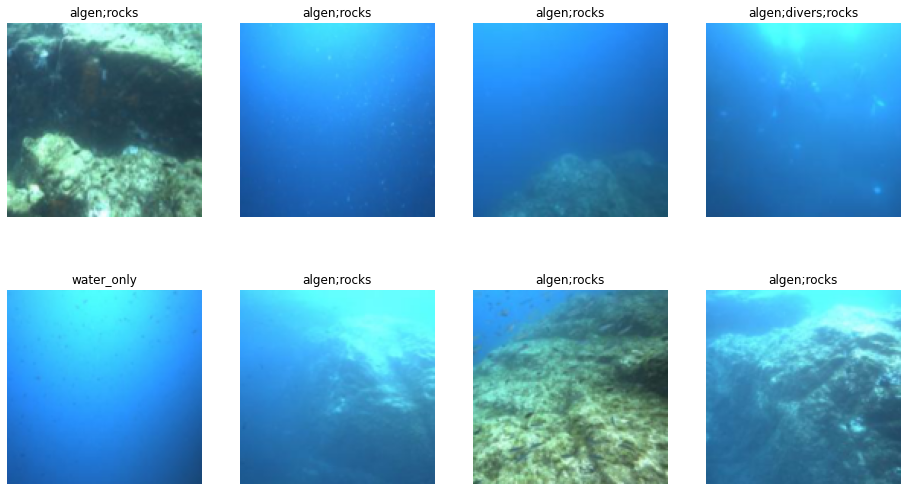

In [16]:
# show some datas
dls.show_batch(nrows=2, ncols=4, figsize=(16,9))

## 3. Model 

In [12]:
# loss function: Flattened Binary Cross Entropy with logits Loss. Its  combine a log and sigmoid function. 
# The outputs of the model are logits


# set up the model: resnet18, dataloaders, loss_function and metrics
learn = vision_learner(dls, resnet18, metrics=[partial(accuracy_multi, thresh=0.5),
                                               precision_multi,
                                               recall_multi,
                                               f1_macro])

SuggestedLRs(valley=0.0030199517495930195)

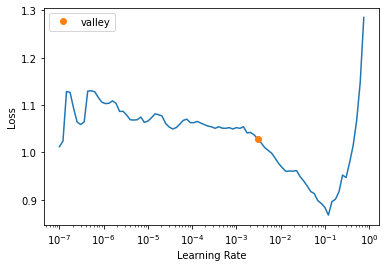

In [13]:
# find the optimal learning rate
learn.lr_find()

In [14]:
# training loop freeze all weights of  the layers excepts the few last for 5 epochs, 
# fine tune on all the weights of the layers for 4 epochs
LR = 3e-3
learn.fine_tune(3, base_lr=LR, freeze_epochs=5)

epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,F1(macro),time
0,0.906320,0.616346,0.696970,0.461719,0.767595,0.473116,00:03
1,0.744473,0.447661,0.814719,0.543531,0.863260,0.596014,00:03
2,0.540978,0.264166,0.911688,0.713881,0.832920,0.753365,00:03
3,0.337210,0.167854,0.931602,0.811413,0.788607,0.796633,00:03
4,0.272180,0.164973,0.931602,0.767413,0.729339,0.727186,00:03


epoch,train_loss,valid_loss,accuracy_multi,precision_score,recall_score,F1(macro),time
0,0.246548,0.221272,0.934199,0.819017,0.759860,0.743484,00:04
1,0.211048,0.145300,0.935065,0.823181,0.793734,0.800504,00:04
2,0.184954,0.129180,0.941125,0.850642,0.834183,0.832423,00:04


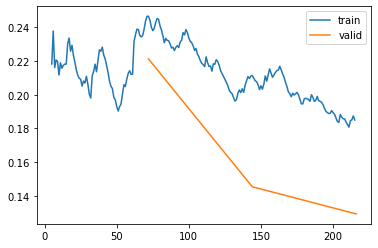

In [15]:
# train and valid loss versus iterations
learn.recorder.plot_loss()
#plt.savefig(path_images_notebook/'losses.png')

In [39]:
# saving models  and exporting if necessary
# learn.save(path_save_models/'resnet18_320x240_epochs_5_4')
# learn.export(path_save_models/'resnet18_320x240_epochs_5_4.pkl')

## 4. Results

/home/ben/anaconda3/envs/fastai_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ben/anaconda3/envs/fastai_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ben/anaconda3/envs/fastai_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


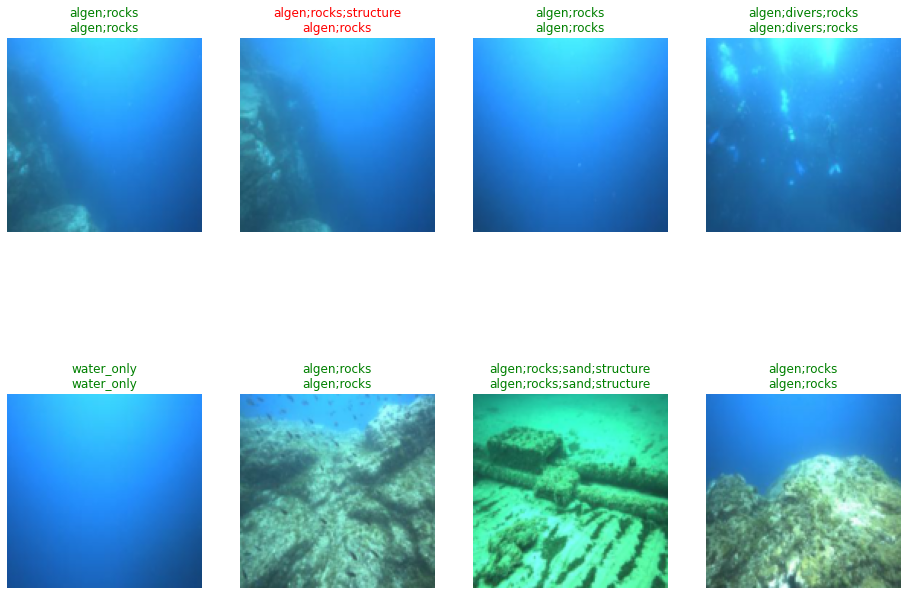

In [17]:
# saving figure if necessary
# the first label at the top of each picture is the ground truth
# the second label below is the prediction
learn.show_results(figsize=(16,12))
#plt.savefig(path_images_notebook/'result3.png')

/home/ben/anaconda3/envs/fastai_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ben/anaconda3/envs/fastai_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ben/anaconda3/envs/fastai_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


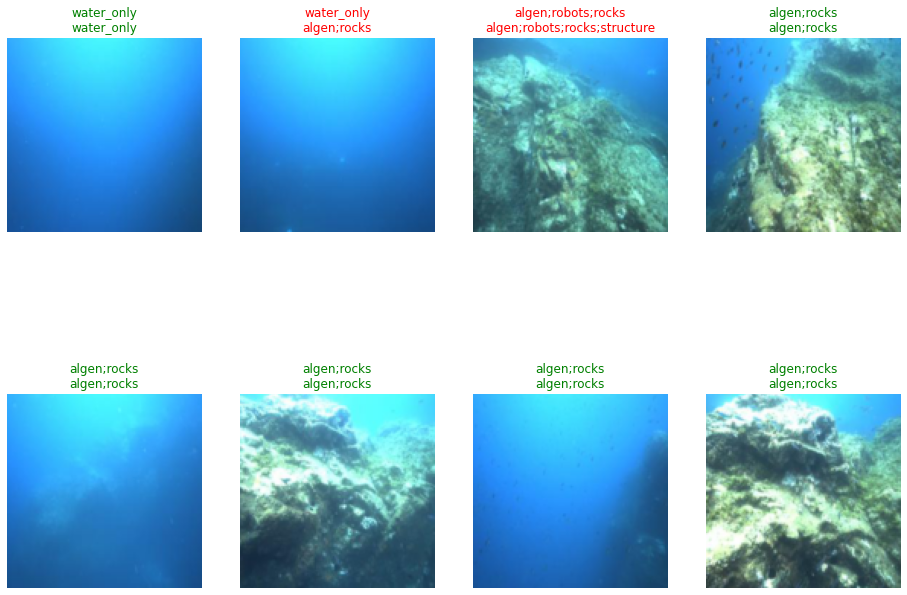

In [21]:
learn.show_results(figsize=(16,12))

In [22]:
interp = Interpretation.from_learner(learn)

/home/ben/anaconda3/envs/fastai_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ben/anaconda3/envs/fastai_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ben/anaconda3/envs/fastai_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/ben/anaco

,target,predicted,probabilities,loss
0,algen;rocks,algen;robots;rocks;structure,"TensorBase([0.9337, 0.0056, 0.9968, 0.9220, 0.0242, 0.6039, 0.0561])",0.9879944920539856
1,algen;robots;rocks;structure,algen;rocks;structure,"TensorBase([9.9514e-01, 1.2847e-01, 6.0185e-03, 9.9653e-01, 6.0433e-04, 8.3164e-01,\n 6.2559e-04])",0.7777650356292725
2,water_only,algen;rocks,"TensorBase([8.8351e-01, 2.3283e-03, 8.3618e-04, 8.2259e-01, 2.5347e-03, 1.4633e-02,\n 2.9622e-01])",0.7309011220932007
3,water_only,algen;rocks,"TensorBase([0.7867, 0.0040, 0.0035, 0.7813, 0.0037, 0.0108, 0.2789])",0.6234556436538696


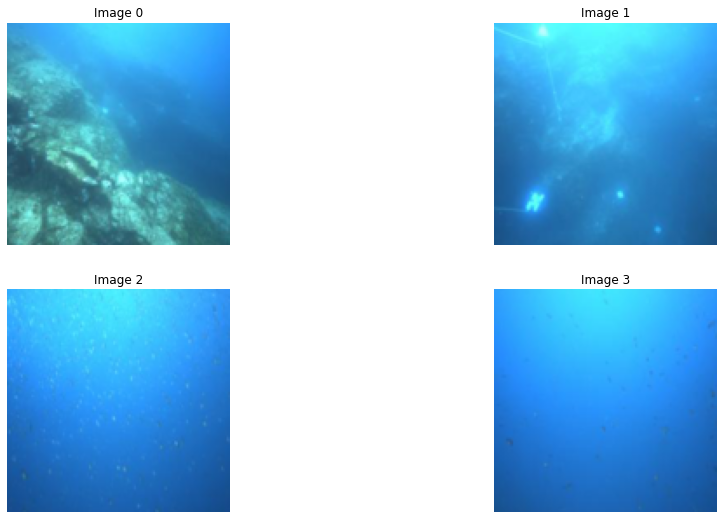

In [23]:
# loooking the images with top losses
interp.plot_top_losses(4, figsize=(16,9))